### Undestanding Data
**This dataset contains information about different houses such as size,
rooms, age, and other features, and the goal is to predict the price of each house.**

### Buisness Undestanding
**Real estate companies use this data to estimate a fair selling price, understand what factors increase or decrease value, and make better buying and pricing decisions.**

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [116]:
## Load Data
dataset = pd.read_csv(r"C:\Users\Noman Traders\Downloads\Housing.csv")

In [117]:
dataset.head(3)

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished


In [118]:
## Checking null values
dataset.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

In [119]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   bedrooms          545 non-null    int64 
 3   bathrooms         545 non-null    int64 
 4   stories           545 non-null    int64 
 5   mainroad          545 non-null    object
 6   guestroom         545 non-null    object
 7   basement          545 non-null    object
 8   hotwaterheating   545 non-null    object
 9   airconditioning   545 non-null    object
 10  parking           545 non-null    int64 
 11  prefarea          545 non-null    object
 12  furnishingstatus  545 non-null    object
dtypes: int64(6), object(7)
memory usage: 55.5+ KB


In [120]:
for i in dataset.columns:
    print(i, " : ", dataset[i].nunique())

price  :  219
area  :  284
bedrooms  :  6
bathrooms  :  4
stories  :  4
mainroad  :  2
guestroom  :  2
basement  :  2
hotwaterheating  :  2
airconditioning  :  2
parking  :  4
prefarea  :  2
furnishingstatus  :  3


In [121]:
dataset.shape

(545, 13)

In [122]:
dataset.size

7085

In [123]:
## handle or remove duplicate values 
dataset.duplicated().sum()


np.int64(0)

### Handling & Removing Outliers 

In [124]:
## Using kurtosis
dataset1 = dataset.copy() 
for col in dataset1.select_dtypes(include=['int64', 'float64']).columns:
    kurt = dataset1[col].kurt()
    if kurt > 3:
        print(col, "=> Leptokurtic")
    elif kurt == 3:
        print(col, "=> Mesokurtic")
    else:
        print(col, "=> Platykurtic")


price => Platykurtic
area => Platykurtic
bedrooms => Platykurtic
bathrooms => Platykurtic
stories => Platykurtic
parking => Platykurtic


In [125]:
### Using Skew to check in which side data is much spread
for col in dataset1.select_dtypes(include=['int64', 'float64']).columns:
    skew = dataset1[col].skew()
    print(f"{col} skewness: {skew:.2f}", end=" => ")

    if skew > 0.5:
        print("Right Skew")
    elif skew < -0.5:
        print("Left Skew")
    else:
        print("Approximately Normal")
   


price skewness: 1.21 => Right Skew
area skewness: 1.32 => Right Skew
bedrooms skewness: 0.50 => Approximately Normal
bathrooms skewness: 1.59 => Right Skew
stories skewness: 1.08 => Right Skew
parking skewness: 0.84 => Right Skew


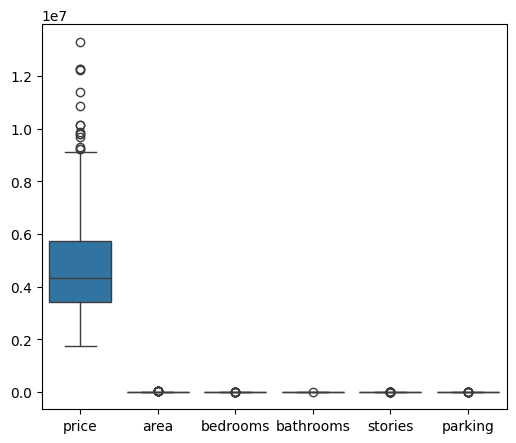

In [126]:
plt.figure(figsize=(6, 5))
sns.boxplot(data=dataset)
plt.show()

In [127]:
q1 = dataset1["price"].quantile(0.25)
q3 = dataset1["price"].quantile(0.75)
iqr = q3 - q1
low_range = q1 - (1.5 * iqr)
high_range = q3 + (1.5 * iqr)

dataset1 = dataset1[(dataset1["price"] >= low_range) & (dataset1["price"] <= high_range)]


In [128]:
dataset1.shape

(530, 13)

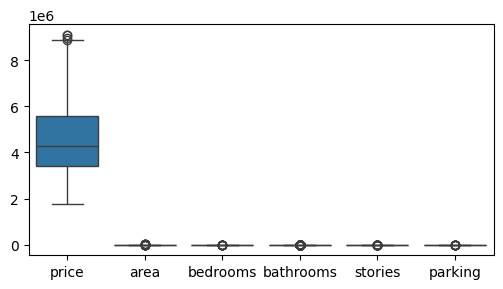

In [129]:
plt.figure(figsize=(6, 3))
sns.boxplot(data=dataset1)
plt.show()

### Applying Encoding

In [130]:
en_data = dataset1[['mainroad', 'guestroom', 'basement', 'hotwaterheating',
       'airconditioning', 'prefarea', 'furnishingstatus']]

In [131]:
pd.get_dummies(en_data).info()

<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 15 to 544
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype
---  ------                           --------------  -----
 0   mainroad_no                      530 non-null    bool 
 1   mainroad_yes                     530 non-null    bool 
 2   guestroom_no                     530 non-null    bool 
 3   guestroom_yes                    530 non-null    bool 
 4   basement_no                      530 non-null    bool 
 5   basement_yes                     530 non-null    bool 
 6   hotwaterheating_no               530 non-null    bool 
 7   hotwaterheating_yes              530 non-null    bool 
 8   airconditioning_no               530 non-null    bool 
 9   airconditioning_yes              530 non-null    bool 
 10  prefarea_no                      530 non-null    bool 
 11  prefarea_yes                     530 non-null    bool 
 12  furnishingstatus_furnished       530 non-null    bool 

In [132]:
ohe = OneHotEncoder(drop="first")

In [133]:
ohe.fit(en_data)

,categories,'auto'
,drop,'first'
,sparse_output,True
,dtype,<class 'numpy.float64'>
,handle_unknown,'error'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [134]:
arr = ohe.transform(en_data).toarray()

In [135]:
cat_cols = en_data.columns
column = ohe.get_feature_names_out(cat_cols)
encoded_df = pd.DataFrame(arr, columns=column)

dataset1 = dataset1.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

final_df = pd.concat([dataset1.drop(columns=cat_cols), encoded_df], axis=1)

In [136]:
final_df.sample(5)

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
103,5950000,6420,3,1,1,0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
76,6419000,6750,2,1,1,2,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
29,7560000,6000,4,2,4,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
91,6160000,5450,4,2,1,0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0
214,4690000,9667,4,2,2,1,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0


#### Apply transformation

In [137]:

transformation_df = final_df[["price", "area"]]

In [138]:
transformation_df = np.sqrt(transformation_df)

C:\Users\Noman Traders\AppData\Local\Temp\ipykernel_7500\2683449546.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset1["price"])
C:\Users\Noman Traders\AppData\Local\Temp\ipykernel_7500\2683449546.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformation_df["price"])


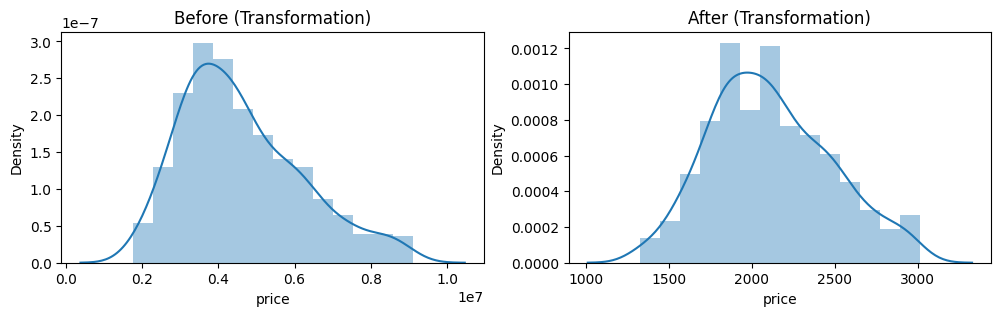

In [139]:
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
sns.distplot(dataset1["price"])
plt.title("Before (Transformation)")

plt.subplot(1,2,2)
sns.distplot(transformation_df["price"])
plt.title("After (Transformation)")
plt.show()

C:\Users\Noman Traders\AppData\Local\Temp\ipykernel_7500\833800371.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset1["area"])
C:\Users\Noman Traders\AppData\Local\Temp\ipykernel_7500\833800371.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(transformation_df["area"])


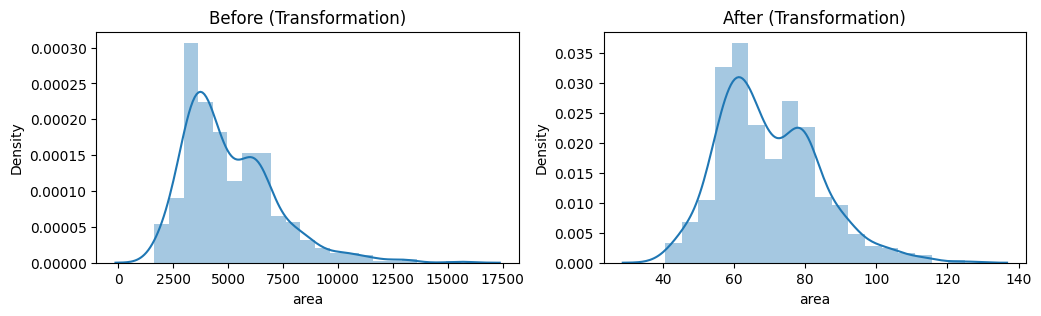

In [140]:
plt.figure(figsize=(12, 3))
plt.subplot(1,2,1)
sns.distplot(dataset1["area"])
plt.title("Before (Transformation)")

plt.subplot(1,2,2)
sns.distplot(transformation_df["area"])
plt.title("After (Transformation)")
plt.show()

**MinMax/Normalization Scalling**

In [141]:
mms = MinMaxScaler()

In [142]:
mms.fit(transformation_df[["area"]])

,feature_range,"(0, ...)"
,copy,True
,clip,False


In [143]:
final_df[["area"]] = mms.transform(transformation_df[["area"]])

**Using Standard Scalling**

In [144]:
ss = StandardScaler()

In [145]:
ss.fit(transformation_df[["price"]])

,copy,True
,with_mean,True
,with_std,True


In [146]:
final_df[["price"]] = ss.transform(transformation_df[["price"]])

In [147]:
final_df.sample(4)

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
485,-1.322245,0.145881,3,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
174,0.359877,0.223989,2,1,1,0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
118,0.812976,0.340080,3,1,3,0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
384,-0.665119,0.535264,2,1,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


**Check Relationship b/w features**

In [148]:
final_df.corr()

,price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,prefarea_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished
price,1.000000,0.542987,0.336339,0.449177,0.423992,0.327780,0.322675,0.293802,0.210084,0.079544,0.458450,0.302311,0.111885,-0.316196
area,0.542987,1.000000,0.117521,0.146288,0.079405,0.348252,0.311454,0.175475,0.036686,-0.001704,0.233105,0.207300,0.018317,-0.144254
bedrooms,0.336339,0.117521,1.000000,0.350025,0.404628,0.110234,-0.024639,0.076559,0.100002,0.029208,0.146859,0.066364,0.060348,-0.120973
bathrooms,0.449177,0.146288,0.350025,1.000000,0.308026,0.127184,0.023649,0.147393,0.120375,0.040149,0.174966,0.032021,0.020264,-0.128037
stories,0.423992,0.079405,0.404628,0.308026,1.000000,0.019222,0.116551,0.038356,-0.166370,0.020024,0.281968,0.026019,0.003122,-0.082920
parking,0.327780,0.348252,0.110234,0.127184,0.019222,1.000000,0.197896,0.030815,0.031970,0.051929,0.128370,0.062606,0.050973,-0.146888
mainroad_yes,0.322675,0.311454,-0.024639,0.023649,0.116551,0.197896,1.000000,0.091658,0.041974,-0.017305,0.099208,0.194901,0.012027,-0.129950
guestroom_yes,0.293802,0.175475,0.076559,0.147393,0.038356,0.030815,0.091658,1.000000,0.372114,-0.025219,0.135385,0.170439,0.012281,-0.104094
basement_yes,0.210084,0.036686,0.100002,0.120375,-0.166370,0.031970,0.041974,0.372114,1.000000,0.000294,0.040937,0.228963,0.050443,-0.110257
hotwaterheating_yes,0.079544,-0.001704,0.029208,0.040149,0.020024,0.051929,-0.017305,-0.025219,0.000294,1.000000,-0.121215,-0.047207,0.064035,-0.051866


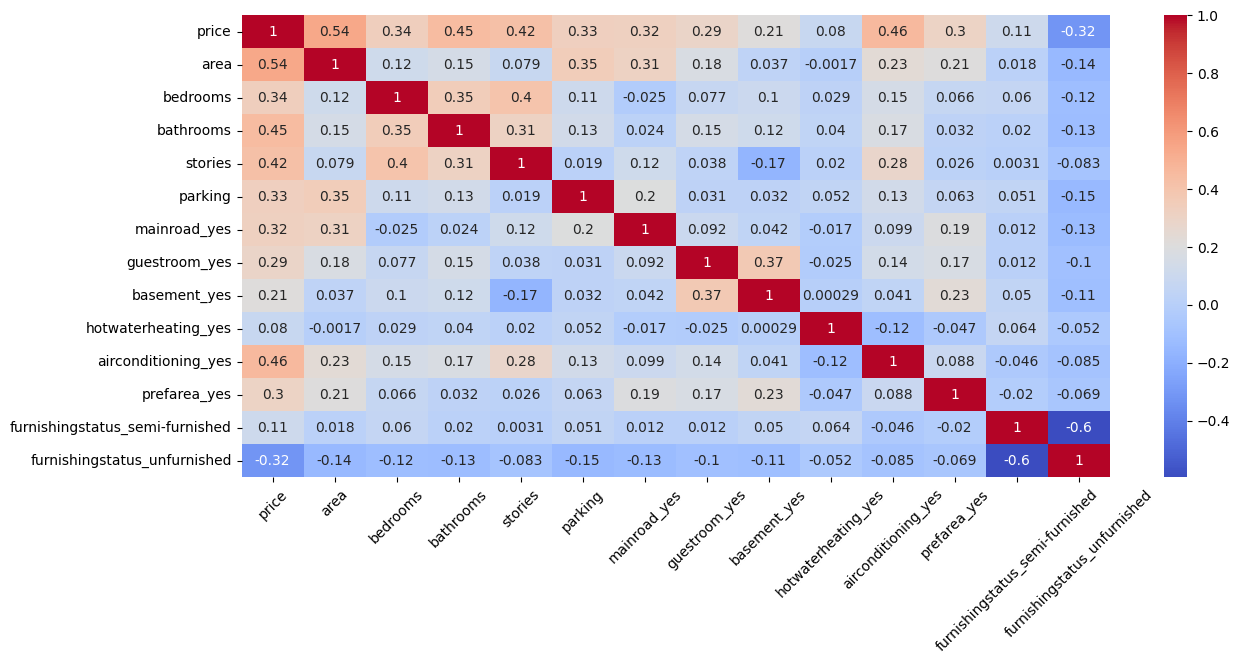

In [149]:
plt.figure(figsize=(14, 6))
sns.heatmap(data=final_df.corr(), annot=True, cmap="coolwarm")
plt.xticks(rotation=45)
plt.show()


**Multi-Stage Feature Selection Pipleline**

In [150]:
# Percentile Based Feature Selection
variance = final_df.var()
p10 = variance.quantile(0.10)
p25 = variance.quantile(0.25)

print("=== Percentile Based Threshold ===")
print("\np10 Threshold: ", p10)
print("p25 Threshold: ", p25)
print("Feature above p10: ", variance[variance > p10].index.tolist())
print("Feature above p25: ", variance[variance > p25].index.tolist())

# Singnal-to-noise (snr)
target = "price"
if target in final_df.columns:
    target_var = final_df[target].var()

    snr = variance/target_var
    print("\n=========== SNR Values ============")
    print(snr)

# Stability Variance Analysis
kf = KFold(n_splits=5, shuffle=True, random_state=42)
stability_matrix = []

for train_idx, _ in kf.split(final_df):

    split_var = final_df.iloc[train_idx].var()
    stability_matrix.append(split_var)

stability_matrix = pd.DataFrame(stability_matrix)
stability_std = stability_matrix.std()



=== Percentile Based Threshold ===

p10 Threshold:  0.06643720797517566
p25 Threshold:  0.15206601990227203
Feature above p10:  ['price', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes', 'guestroom_yes', 'basement_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
Feature above p25:  ['price', 'bedrooms', 'bathrooms', 'stories', 'parking', 'basement_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']

=========== SNR Values ============
price                              1.000000
area                               0.027036
bedrooms                           0.532645
bathrooms                          0.215222
stories                            0.740249
parking                            0.709847
mainroad_yes                       0.124176
guestroom_yes                      0.144681
basement_yes                       0.226643
hotwaterheating_yes         

**Split Data into Training and Spliting**

In [151]:
# Percentile-Based Thresold
variance = final_df.var()
p10 = variance.quantile(0.10)
p25 = variance.quantile(0.25)

print("==== Perecntile-Based Treshold ====")
print("p10 Threshold: ", p10)
print("p25 Threshold: ", p25)
print("Feature above >p10: ", variance[variance > p10].index.tolist())
print("Feature above >p25: ", variance[variance > p25].index.tolist())

# Signal-to-noise (snr)
target = "price"
if target in final_df.columns:
    target_var = final_df[target].var()

    snr = variance/target_var
    print("\n========== SNR Values ===========")
    print(snr)

# Variance Stability (STD across split)

kf = KFold(n_splits=5, shuffle=True, random_state= 42)
stability_matrix = []
for train_idx, _ in kf.split(final_df):

    split_var = final_df.iloc[train_idx].var()
    stability_matrix.append(split_var)

stability_matrix = pd.DataFrame(stability_matrix)
stability_std = stability_matrix.std()

print("\n===== Variance Stability (STD across split) =====")
print(stability_std)


stable_features = stability_std[stability_std < 0.05].index.tolist()
print("\nStable Features (<0.05 STD): ", stable_features)

# Final Decision
correlation = final_df.corrwith(final_df["price"]).abs()
aligned_corr = correlation.reindex(variance.index).fillna(0)
final_keep = variance[(variance > p10) | (aligned_corr > 0.1)].index.tolist()

print("\n======= Final Recommended Features ==========")
print(final_keep)

==== Perecntile-Based Treshold ====
p10 Threshold:  0.06643720797517566
p25 Threshold:  0.15206601990227203
Feature above >p10:  ['price', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes', 'guestroom_yes', 'basement_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']
Feature above >p25:  ['price', 'bedrooms', 'bathrooms', 'stories', 'parking', 'basement_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']

========== SNR Values ===========
price                              1.000000
area                               0.027036
bedrooms                           0.532645
bathrooms                          0.215222
stories                            0.740249
parking                            0.709847
mainroad_yes                       0.124176
guestroom_yes                      0.144681
basement_yes                       0.226643
hotwaterheating_yes         

**Train Test & Split**

In [152]:
final_df = final_df[['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking', 'mainroad_yes', 'guestroom_yes', 'basement_yes', 'airconditioning_yes', 'prefarea_yes', 'furnishingstatus_semi-furnished', 'furnishingstatus_unfurnished']]

In [153]:
x = final_df.drop("price", axis=1)
y = final_df["price"]

In [154]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [155]:
lr = LinearRegression()

In [156]:
lr.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [157]:
accuracy = lr.score(x_test, y_test)*100
print("Accuracy: ", accuracy)

Accuracy:  68.62851548112351


In [158]:
print("Mean square Error: ", mean_squared_error(y_test, lr.predict(x_test)))
print("Mean Absolute Error: ", mean_absolute_error(y_test, lr.predict(x_test)))
print("Root mean Square Error: ", np.sqrt(mean_squared_error(y_test, lr.predict(x_test))))

Mean square Error:  0.4318877392220181
Mean Absolute Error:  0.48869491758258626
Root mean Square Error:  0.6571816637901716


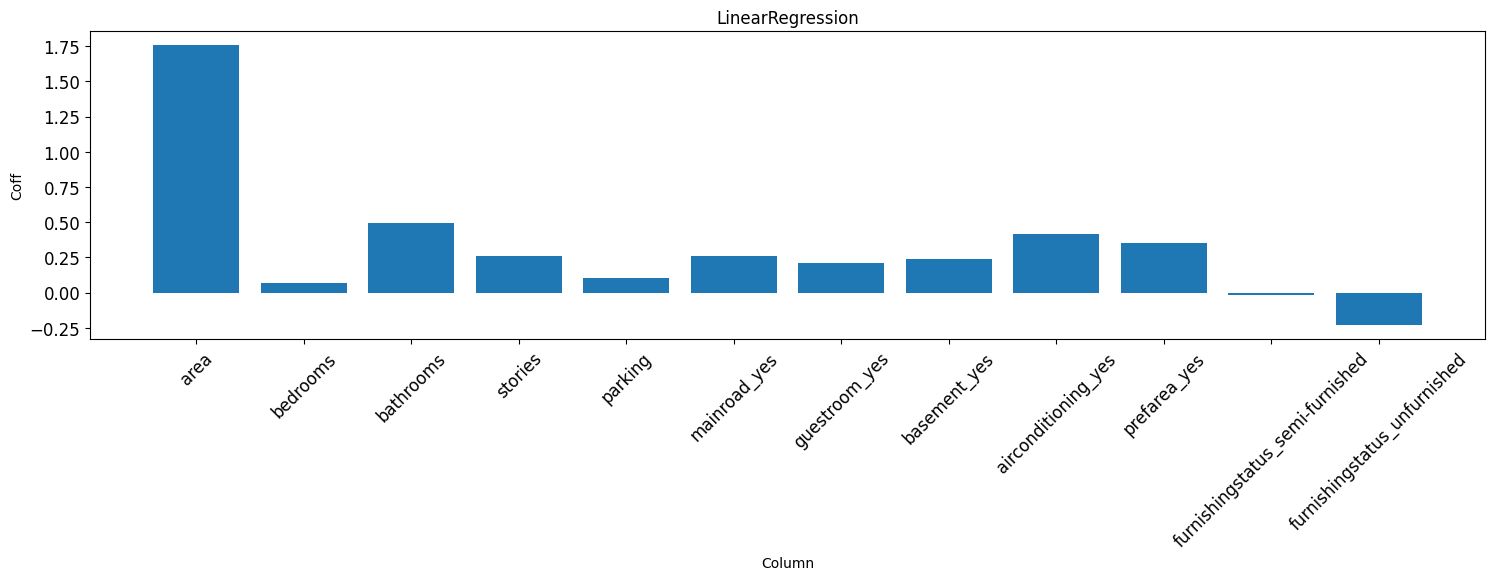

In [159]:
plt.figure(figsize=(18, 4))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.bar(x.columns, lr.coef_)
plt.title("LinearRegression")
plt.xlabel("Column")
plt.ylabel("Coff")
plt.show()


## Lasso

In [160]:
la = Lasso(alpha=0.01)

In [161]:
la.fit(x_train, y_train)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [162]:
la.score(x_test, y_test)*100

66.91192078373206

In [163]:
print("Mean square Error: ", mean_squared_error(y_test, la.predict(x_test)))
print("Mean Absolute Error: ", mean_absolute_error(y_test, la.predict(x_test)))
print("Root mean Square Error: ", np.sqrt(mean_squared_error(y_test, la.predict(x_test))))

Mean square Error:  0.45551990755535954
Mean Absolute Error:  0.5040243459407231
Root mean Square Error:  0.6749221492552748


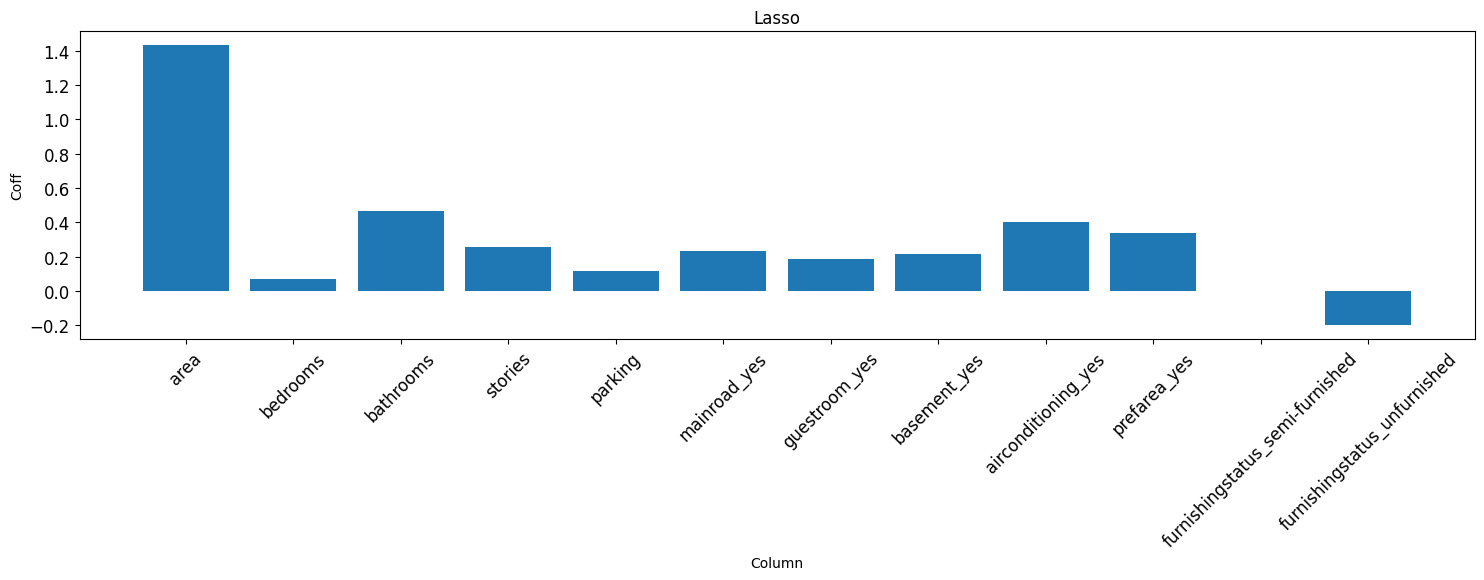

In [164]:
plt.figure(figsize=(18, 4))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.bar(x.columns, la.coef_)
plt.title("Lasso")
plt.xlabel("Column")
plt.ylabel("Coff")
plt.show()


## Ridge

In [165]:
ri = Ridge(alpha=100)
ri.fit(x_train, y_train)

,alpha,100
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [166]:
ri.score(x_test, y_test)*100

53.34749609221501

In [167]:
ri.score(x_train, y_train)*100

54.185670198260084

In [168]:
print("Mean square Error: ", mean_squared_error(y_test, ri.predict(x_test)))
print("Mean Absolute Error: ", mean_absolute_error(y_test, ri.predict(x_test)))
print("Root mean Square Error: ", np.sqrt(mean_squared_error(y_test, ri.predict(x_test))))

Mean square Error:  0.6422598340749869
Mean Absolute Error:  0.6356850997229905
Root mean Square Error:  0.8014111517036601


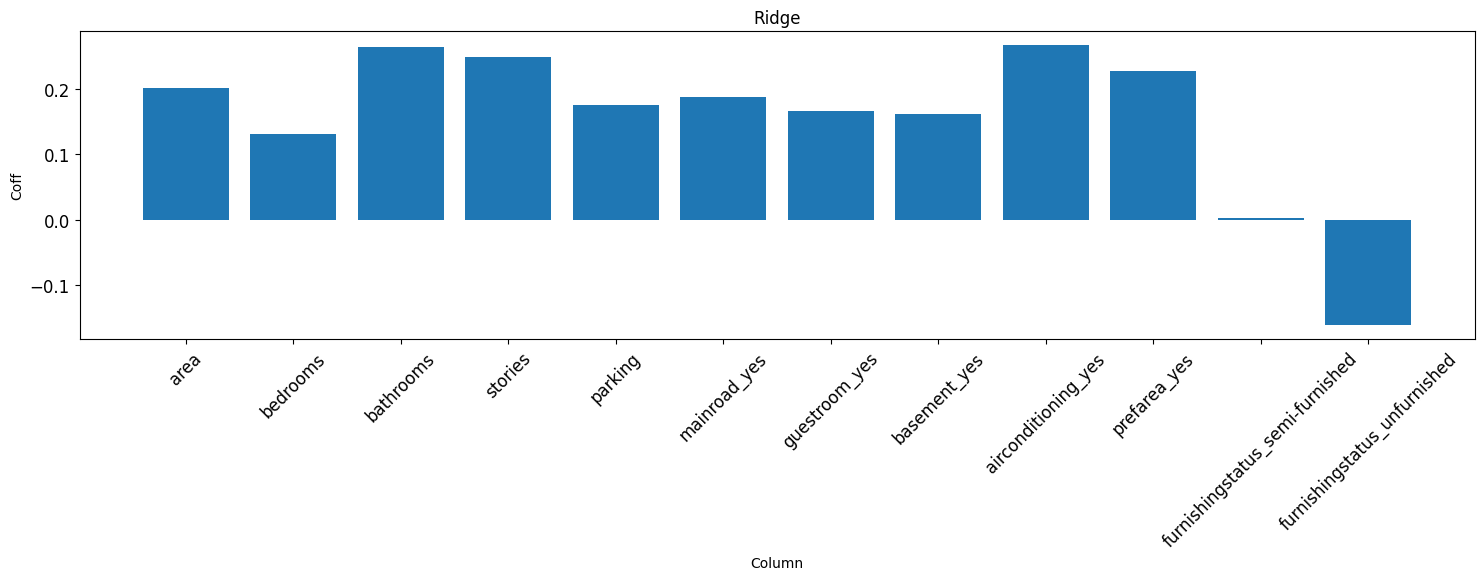

In [169]:
plt.figure(figsize=(18, 4))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.bar(x.columns, ri.coef_)
plt.title("Ridge")
plt.xlabel("Column")
plt.ylabel("Coff")
plt.show()


In [170]:
df = pd.DataFrame({
    "col_name":x.columns,
    "LinearRegression":lr.coef_,
    "Lasso": la.coef_,
    "Ridge": ri.coef_
})

In [171]:
df

,col_name,LinearRegression,Lasso,Ridge
0,area,1.755407,1.431644,0.201563
1,bedrooms,0.071009,0.071422,0.130481
2,bathrooms,0.493250,0.468530,0.264484
3,stories,0.258808,0.258186,0.248716
4,parking,0.106082,0.118086,0.175216
5,mainroad_yes,0.257510,0.233931,0.186984
6,guestroom_yes,0.210385,0.188848,0.166957
7,basement_yes,0.241513,0.218097,0.161990
8,airconditioning_yes,0.418983,0.405161,0.266481
9,prefarea_yes,0.349614,0.336591,0.227705
